In [1]:
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from utils import rebin1d, rebin1dx
from scipy.ndimage import gaussian_filter1d

#Thomas's calibration on VLS and MEBS
def PhoEng_VLS(pix):
    return (pix-1337)*(382-349)/(1150-800)+401.5

def KE_MBES(tof,retV,d=2.09425753,t0=1.9e-1):
    't in mus, d in m, KE in eV'
    return (0.5*9.11*d**2/1.60)/((tof-t0)**2)+retV

In [2]:
def wf_vls(hfnm,hfn=75,xt = np.linspace(0.5,2,1500),vlsx = np.linspace(500,1500,125),gmdth = 10e-3):
    hf = h5py.File(hfnm,'r')
    
    #vls max
    maxs_vls = np.max(hf['vls'][:],axis=1)
    
    #vls max index
    xmaxs_vls = np.argmax(hf['vls'][:],axis=1)    
    
    #filter on max_vls/gmd
  #  vind = (((maxs_vls>np.percentile(maxs_vls,35))&(hf['gmd_energy'][:]>gmdth)))   
    vind = (hf['gmd_energy'][:]>gmdth)   
       
    #get VLS spectrum center of mass    
    vls = hf['vls'][:][vind]
    x_vls = np.arange(vls.shape[1]) 
    xmaxs_vls = xmaxs_vls[vind]
    x_vls_m =np.tile(x_vls.reshape((1,-1)),(vls.shape[0],1))   
    inds = (x_vls_m>(xmaxs_vls-hfn)[:,np.newaxis]) & (x_vls_m<(xmaxs_vls+hfn)[:,np.newaxis])     
    vls[~inds] = 0
    com_vls = np.average(x_vls_m,weights=vls,axis=1) 
 
    #histogram wfpks vs. vls com   
    pks = hf['MBESpk_t'][:][vind][:,:100]
    comm = np.tile(com_vls.reshape([-1,1]),(1,pks.shape[1]))
    pks = np.nan_to_num(pks,nan=-100)    
    hMpk,_,_=np.histogram2d(comm.flatten(),pks.flatten(),bins=[vlsx,xt]) 
    
    #find GMD normalization constants
    gmdx = np.arange(0.,100*1e-3,1e-4)
    hgmd,_,_ = np.histogram2d(com_vls,hf['gmd_energy'][:][vind],bins=[vlsx,gmdx])
    norm = hgmd*((gmdx[:-1]+gmdx[1:])/2).reshape([1,-1])
    norm = norm.sum(1)
    
    hf.close()
    return norm, hMpk

In [3]:
xt = np.arange(0,2,0.001)
vlsx = np.arange(700,1800,1)
for ii,i in enumerate(np.arange(23,39)):
    print(i)
    hfnm = '/reg/d/psdm/tmo/tmox40018/scratch/preproc/v1/run'+str(i)+'_v1.h5'
    norm1, hVM1 = wf_vls(hfnm=hfnm,hfn=75,xt = xt,vlsx = vlsx,gmdth=5e-3)
    if ii==0:
        norm = norm1
        hVM = hVM1
    else:
        norm += norm1
        hVM += hVM1

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [4]:
norm[norm==0] = 1e-10
hVM = hVM/(norm[:,np.newaxis])

<IPython.core.display.Javascript object>


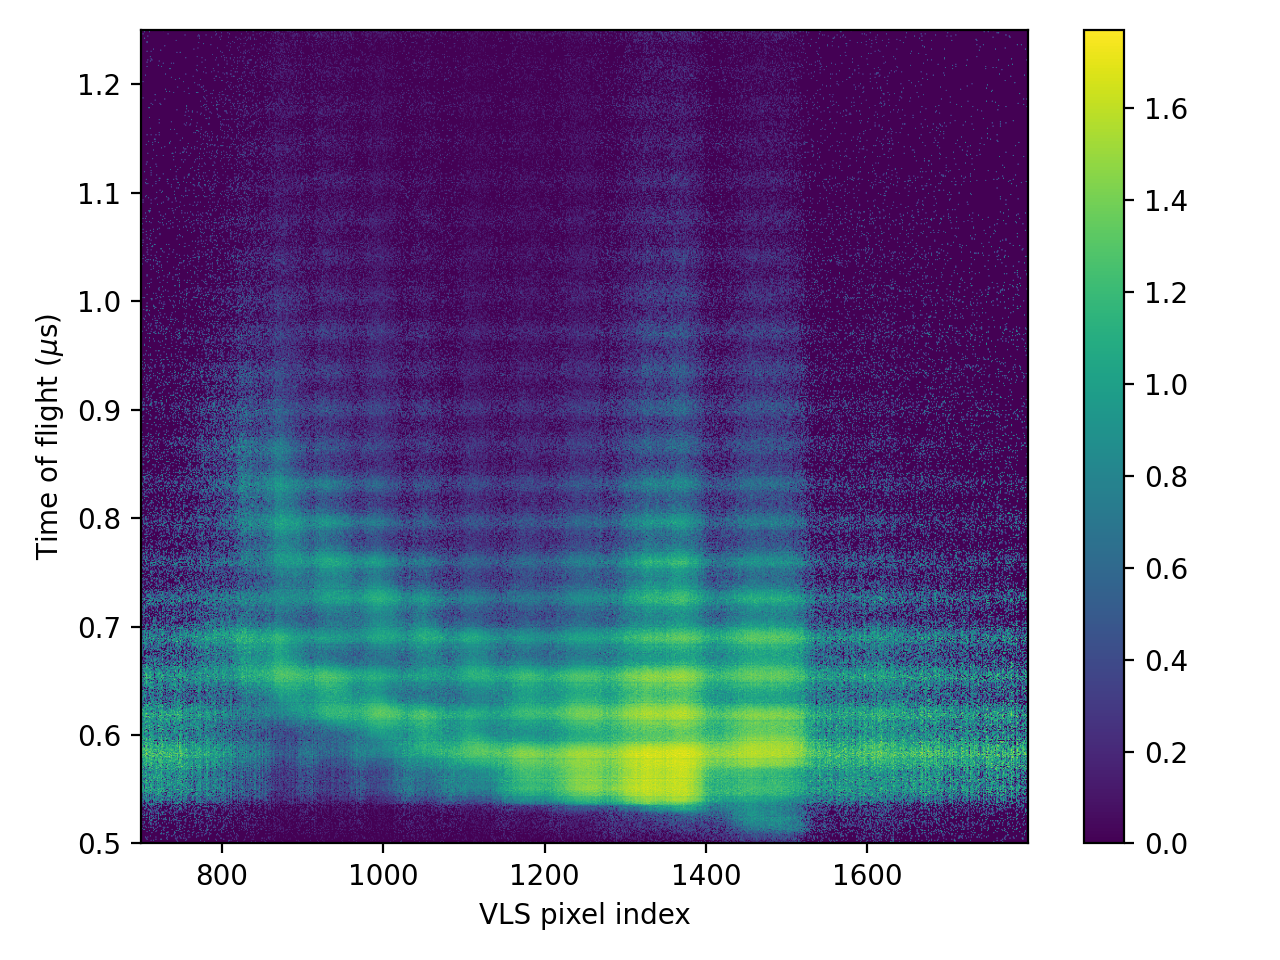

In [5]:
plt.figure()
plt.imshow(np.log10(np.rot90(hVM)+1),aspect='auto',
            extent=[vlsx[0],vlsx[-1],xt[0],xt[-1]])#,vmin=0,vmax=60)
plt.colorbar()
plt.ylim(0.5,1.25)
plt.xlabel('VLS pixel index')
plt.ylabel(r'Time of flight ($\mu$s)')
plt.tight_layout()

<IPython.core.display.Javascript object>


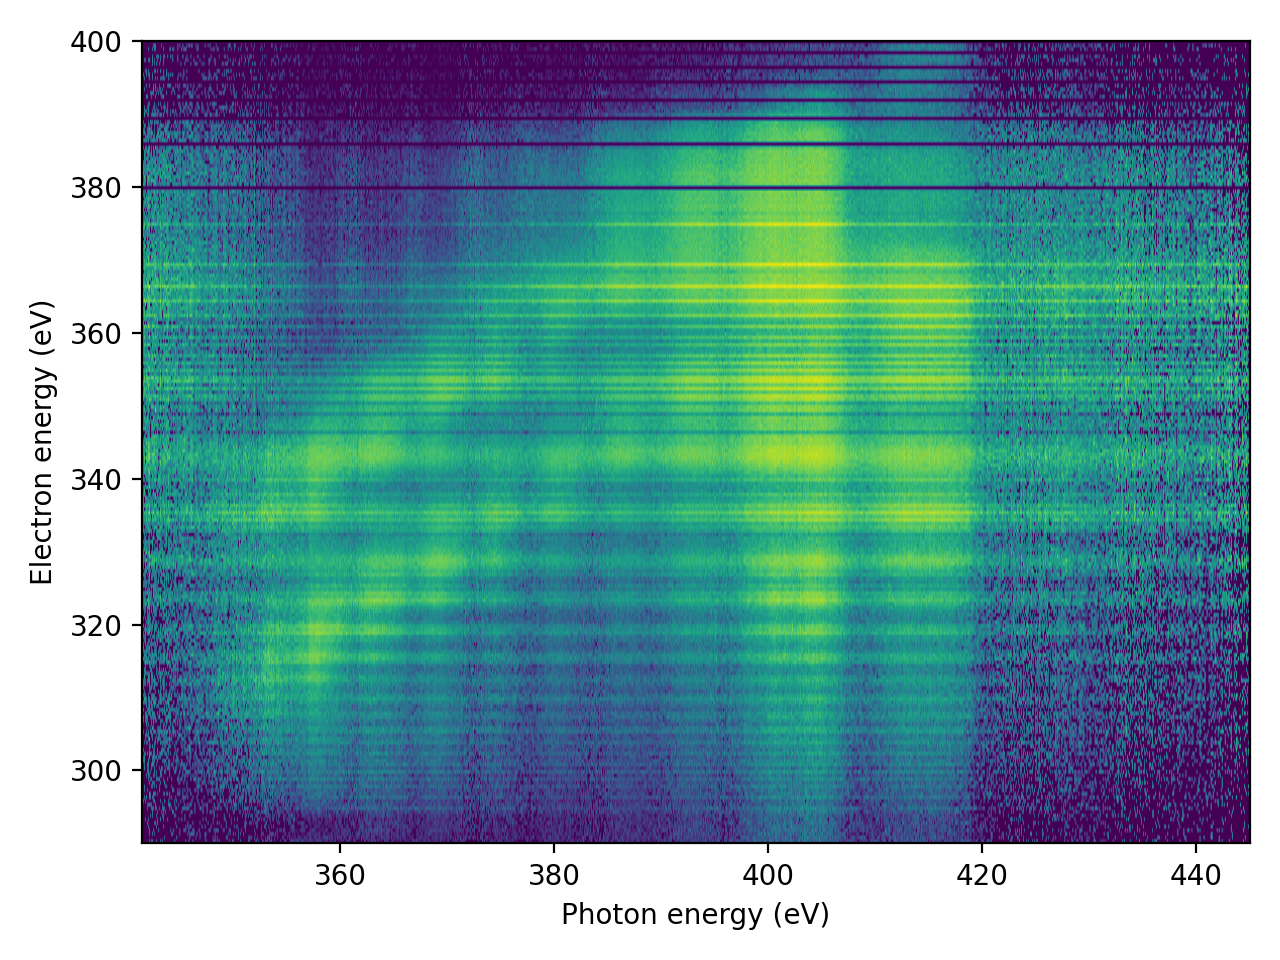

In [6]:
plt.figure()
pE = PhoEng_VLS((vlsx[1:]+vlsx[:-1])/2)
eE = KE_MBES((xt[1:]+xt[:-1])/2,285)

xE = np.arange(0,450,0.5)

hE = np.array([list(np.histogram(eE,bins=xE,weights=hVM[i,:])[0]) for i in range(len(hVM))])

plt.imshow(np.log10(np.rot90(hE)+1),aspect='auto',
            extent=[pE[0],pE[-1],xE[0],xE[-1]])#,vmin=1.9,vmax=3)

plt.ylim(290,400)
plt.xlabel('Photon energy (eV)')
plt.ylabel('Electron energy (eV)')
plt.tight_layout()

<IPython.core.display.Javascript object>


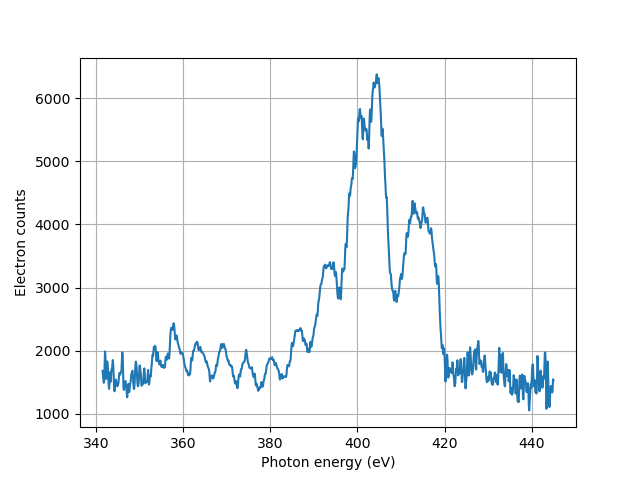

Text(0, 0.5, 'Electron counts')

In [22]:
plt.figure()
plt.plot(pE,gaussian_filter1d(hE.sum(1),1))
plt.grid('on')
plt.xlabel('Photon energy (eV)')
plt.ylabel('Electron counts')